In [3]:
import json
import http.client
from urllib.parse import urlencode, quote_plus, quote
import pandas as pd
from datetime import datetime
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

In [2]:
CLIENT_ID = "aa94502c-1518-4c17-9fba-88f7e6580baf"
API_URL = "api.webstat.banque-france.fr"

# Récupération de la liste des datasets

In [26]:
conn = http.client.HTTPSConnection(API_URL)

headers = {
    'X-IBM-Client-Id': CLIENT_ID,
    'accept': "application/json"
    }

conn.request("GET", "/webstat-fr/v1/catalogue?format=json", headers=headers)

res = conn.getresponse()
data = res.read()

annuaire_dict = data.decode("utf-8")
annuaire_dict = json.loads(annuaire_dict)
dataset_names = [dataset["name"] for dataset in annuaire_dict]

In [27]:
pd.DataFrame(annuaire_dict).to_markdown(buf="catalogue.md", index=False)

In [28]:
dataset_names

['SC1',
 'STS',
 'DIREN',
 'MIR1',
 'CPP',
 'CFT',
 'FM',
 'CONJ2',
 'SA',
 'CONJ',
 'MIR',
 'MNA',
 'IVF1',
 'ESTR',
 'FCI',
 'ECOFI',
 'AME',
 'CDIS',
 'CFANF',
 'CFTDC',
 'BPM6',
 'EXR',
 'CNF',
 'ACPR',
 'PEA',
 'ICP',
 'FATSO',
 'SEC',
 'SI_AI',
 'FTID',
 'ESA',
 'OFC',
 'CEFIT',
 'BLS',
 'QFAGG',
 'SAFE',
 'TCN2',
 'DSE',
 'BSI',
 'ICB',
 'RA_T',
 'ENDET',
 'PME',
 'RPP',
 'GST',
 'DET',
 'CONS',
 'BSI1']

# Récupération de la liste des séries d'un dataset

In [29]:
def get_series_by_dataset_name(dataset_name):
    conn = http.client.HTTPSConnection(API_URL)

    conn.request("GET", 
                 f"/webstat-fr/v1/catalogue/{dataset_name}?format=json", 
                 headers={
                    'X-IBM-Client-Id': CLIENT_ID,
                    'accept': "application/json"
                })

    try:
        res = conn.getresponse()
        data = res.read()

        raw_result = data.decode("utf-8")
        if "The document has moved" in raw_result:
            return []
        else:
            datasets_available = json.loads(raw_result)
            return datasets_available
    except Exception as e:
        raise Exception(dataset_name, raw_result, e.args)

In [30]:
sts_series = get_series_by_dataset_name("STS")
sts_series[0]

{'seriesKey': 'STS.M.BE.Y.TOVV.NS4701.4.000',
 'dataset': 'STS',
 'title': 'Belgique, Indice de ventes au détail (CVS-CJO)',
 'titleCompl': 'Belgique - Indice de ventes au détail, Cvs-cjo',
 'extTitle': 'Belgium, Retail trade turnover index (SA-WDA)',
 'natTitle': 'Belgium - Total Turnover Index, deflated, Retail trade excluding fuel, except of motor vehicles and motorcycles - NACE Rev2; Eurostat; Working day and seasonally adjusted',
 'sourceAgency': '4D0',
 'from': '01/01/1998',
 'to': '01/03/2023',
 'dimensionsValues': [{'DimensionValue': {'code': 'FREQ', 'value': 'M'}},
  {'DimensionValue': {'code': 'REF_AREA', 'value': 'BE'}},
  {'DimensionValue': {'code': 'ADJUSTMENT', 'value': 'Y'}},
  {'DimensionValue': {'code': 'STS_CONCEPT', 'value': 'TOVV'}},
  {'DimensionValue': {'code': 'STS_CLASS', 'value': 'NS4701'}},
  {'DimensionValue': {'code': 'STS_INSTITUTION', 'value': '4'}},
  {'DimensionValue': {'code': 'STS_SUFFIX', 'value': '000'}}]}

In [31]:
series_dict = {}

In [32]:
# création d'un graph des datasets de webstat
import networkx as nx

from bokeh.io import output_file, show
from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx

graph = nx.DiGraph()

for dataset_name in dataset_names:
    if dataset_name in series_dict:
        series = series_dict[dataset_name]
    else:
        series = get_series_by_dataset_name(dataset_name)
        series_dict[dataset_name] = series

    for serie in series:
        serie_key = serie["seriesKey"]
        serie_dataset = serie["dataset"]
        serie_title = serie["title"]

        graph.add_edges_from([(serie_dataset, serie_title if serie_title is not None else serie_key)])

graph_renderer = from_networkx(graph, nx.spring_layout, scale=1, center=(0, 0))

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
graph_renderer.edge_renderer.glyph = MultiLine(line_color="edge_color", line_alpha=0.8, line_width=1)

plot = Plot(width=1000, height=1000, x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.renderers.append(graph_renderer)

output_file("interactive_graphs.html")

# show(plot)

# plt.figure(figsize=(12,12)) 
# nx.draw(graph, with_labels=True, node_size=60,font_size=8)


KeyboardInterrupt: 

In [34]:
all_series = sum(list(series_dict.values()), [])

## Frequency distribution

In [65]:
# 'DimensionValue': {'code': 'FREQ', 'value': 'M'}

all_serie_frequencies = [dimension_value["DimensionValue"]["value"] for serie in all_series for dimension_value in serie["dimensionsValues"] if dimension_value["DimensionValue"]["code"] == "FREQ"]

frequencies = pd.DataFrame(all_serie_frequencies, columns=["freq"])
frequencies["count"] = 1
frequencies.groupby("freq").sum()

,count
freq,
A,1231
M,1408
Q,734
W,1


## Timespan Distribution

In [66]:
# 'from': '01/12/1992', 'to': '01/04/2023'

datetime_format = "%d/%m/%Y"

all_serie_timespans = [(datetime.strptime(serie["from"], datetime_format),
                        datetime.strptime(serie["to"], datetime_format)) for serie in all_series]



In [72]:
all_serie_years = [(all_serie_timespan[0].year, all_serie_timespan[1].year) for all_serie_timespan in all_serie_timespans]

timespan_df = pd.DataFrame(all_serie_years, columns=["from", "to"])
timespan_df["count"] = 1
grouped_timespan_df = timespan_df.groupby(["from", "to"]).sum()

grouped_timespan_df.to_markdown("serie_timespans.md")


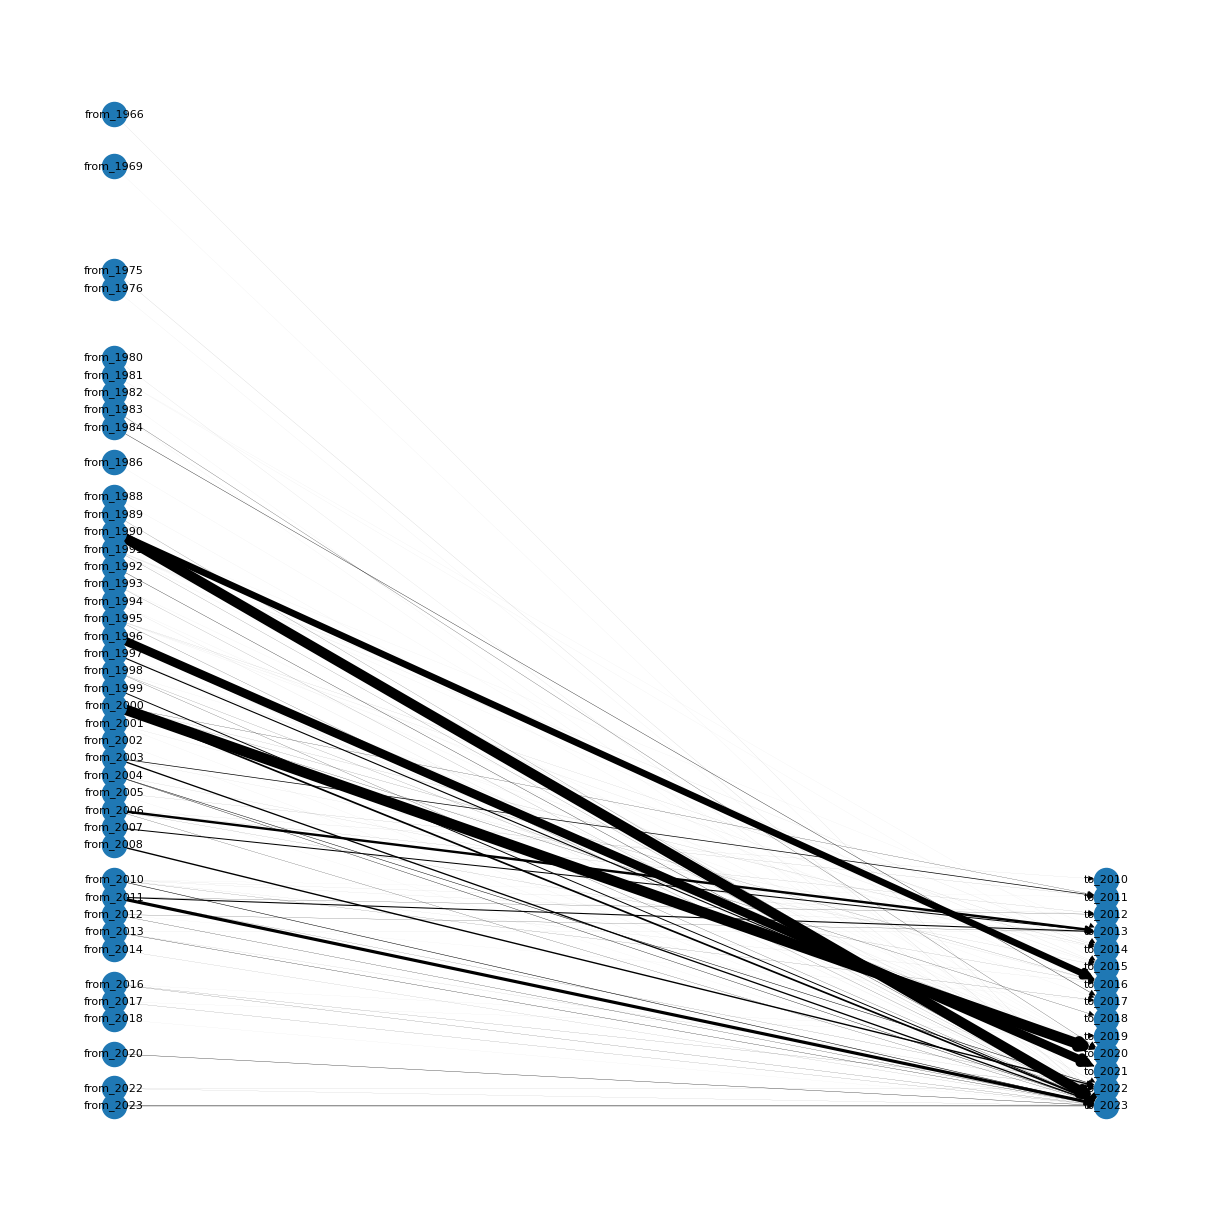

In [120]:
graph = nx.DiGraph()
from_nodes = []
to_nodes = []
for i, row in grouped_timespan_df.iterrows():
        weight = row["count"]
        from_edge = f"from_{row.name[0]}"
        to_edge = f"to_{row.name[1]}"

        from_nodes.append(from_edge)
        to_nodes.append(to_edge)

        graph.add_edge(from_edge, to_edge, weight=weight)

pos = nx.random_layout(graph)
# pos = nx.circular_layout(graph.subgraph(from_nodes + to_nodes))

for i, from_node in enumerate(set(from_nodes)):
        y_pos = -int(from_node.replace("from_", ""))
        pos[from_node] = np.array([-10, y_pos])

for i, to_node in enumerate(set(to_nodes)):
        y_pos = -int(to_node.replace("to_", ""))
        pos[to_node] = np.array([10, y_pos])


edges = graph.edges()
weights = [graph[u][v]['weight'] for u,v in edges]

plt.figure(figsize=(12,12))
nx.draw(graph, pos, with_labels=True, node_size=300, font_size=8, width=np.array(weights) / 80)

## Filter series by **frequency** and **timespan** attributes

In [121]:
# filter by frequency
filtered_series = list(
    filter(
        lambda x:filter(
            lambda y: y["DimensionValue"]["code"] == "FREQ" and y["DimensionValue"]["value"] == "M",
            x["dimensionsValues"]
        ),
        all_series
    )
)

# filter by date
filtered_series = list(
    filter(
        lambda x: datetime.strptime(x["from"], datetime_format).year < 2001 and datetime.strptime(x["to"], datetime_format).year > 2019,
        filtered_series
    )
)

# Récupération des observations d'un dataset
Cet API requête l'ensemble des données d'un dataset. Certains datasets contiennent plusieurs centaines de milliers d'observations. En cas d'erreur (timeout) ou de temps de chargement excessif, il sera nécessaire de restreindre le nombre d'observations demandé à l'aide des différents paramètres ou d'utiliser l'API de requête par séries.

In [154]:

def get_serie_observations(dataset, serie_key, start_period="2000-01-01", end_period="2019-12-31"):
    querystr_dict = {
        "format": "json",
        "detail": "dataonly",
        "startPeriod" : start_period,
        "endPeriod" : end_period,
        # "lastNObservations": last_observations=1,
        # "firstNObservations": first_observations=1,
    }
    querystr = urlencode(querystr_dict)

    headers = {
        'X-IBM-Client-Id': CLIENT_ID,
        'accept': "application/json"
    }

    conn = http.client.HTTPSConnection(API_URL)
    conn.request("GET", f"/webstat-fr/v1/data/{dataset}/{serie_key}?{querystr}", headers=headers)

    res = conn.getresponse()
    data = res.read()

    serie_observations = json.loads(data.decode("utf-8"))
    if "seriesObs" in serie_observations:
        return serie_observations["seriesObs"][0]
    else:
        return None

In [155]:
observations_cache = {}

In [156]:
all_observations = []
for filtered_serie in filtered_series:
    if filtered_serie["seriesKey"] not in observations_cache:
        observations = get_serie_observations(dataset=filtered_serie["dataset"], serie_key=filtered_serie["seriesKey"])
        observations_cache[filtered_serie["seriesKey"]] = observations
    else:
        observations = observations_cache[filtered_serie["seriesKey"]]
    
    if observations:
        all_observations.append(observations)

In [157]:
obs_dict_list = {}
for serie_observations in all_observations:
    obs_dict = {
        datetime.strptime(observation_period["ObservationPeriod"]["periodFirstDate"], "%d-%m-%Y 00:00:00"): observation_period["ObservationPeriod"]["value"]
        for observation_period in serie_observations["ObservationsSerie"]["observations"]
    }
    obs_ds_name = serie_observations["ObservationsSerie"]["title"]
    obs_dict_list[obs_ds_name] = obs_dict


In [158]:
final_df = pd.DataFrame(obs_dict_list)
final_df.to_csv("final_df.csv")

# Import final dataframe

In [9]:
final_df = pd.read_csv("final_df.csv", index_col=0)

# TODO: Move following cells

In [ ]:
french_months = {
    "Jan": 1,
    "Fév": 2,
    "Mar": 3,
    "Avr": 4,
    "Mai": 5,
    "Jun": 6,
    "Jul": 7,
    "Aoû": 8,
    "Sep": 9,
    "Oct": 10,
    "Nov": 11,
    "Déc": 12,
}

In [ ]:
my_df = pd.DataFrame(ds_dict)
datetime_df = []
for index in my_df.index:
    month, year = index.split(" ")
    datetime_df.append(datetime(int(year), french_months[month], 1))

my_df.index = datetime_df
my_df = my_df.sort_index()
# my_df = my_df.asfreq('m')

In [ ]:
my_df_nn = my_df.dropna(axis=1,thresh=300)
my_df_nn = my_df_nn.dropna(axis=0)

# Apply transformations to dataset

* remove null values
* check sequenced datetime index
* normalize time serie values

In [14]:
# TODO problem avec NA
print(final_df.dropna().shape)
print(final_df.shape)

final_df_wona = final_df.dropna(axis=1,thresh=240)
# final_df = final_df.dropna(axis=0)

(19, 1732)
(240, 1732)


In [18]:
normalized_final_df = (final_df_wona - final_df_wona.mean()) / final_df_wona.std()

# Convert to `tslearn` dataset

In [24]:
from tslearn.utils import to_time_series_dataset
X_train = to_time_series_dataset(normalized_final_df.T)

In [27]:
X_train.shape # n_ts, max_sz, d

(517, 240, 1)

In [26]:
for cluster_count in range(2, 7):
    km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw", n_jobs=2, n_init=5)
    labels = km.fit_predict(X_train)
    score = silhouette_score(X_train, labels, metric="dtw", n_jobs=4)
    print(f"{cluster_count}: {score}")


2: 0.3374976481717656
3: 0.32940159530962254
4: 0.2716731425731864
5: 0.2733704787332272
6: 0.2052386960351147


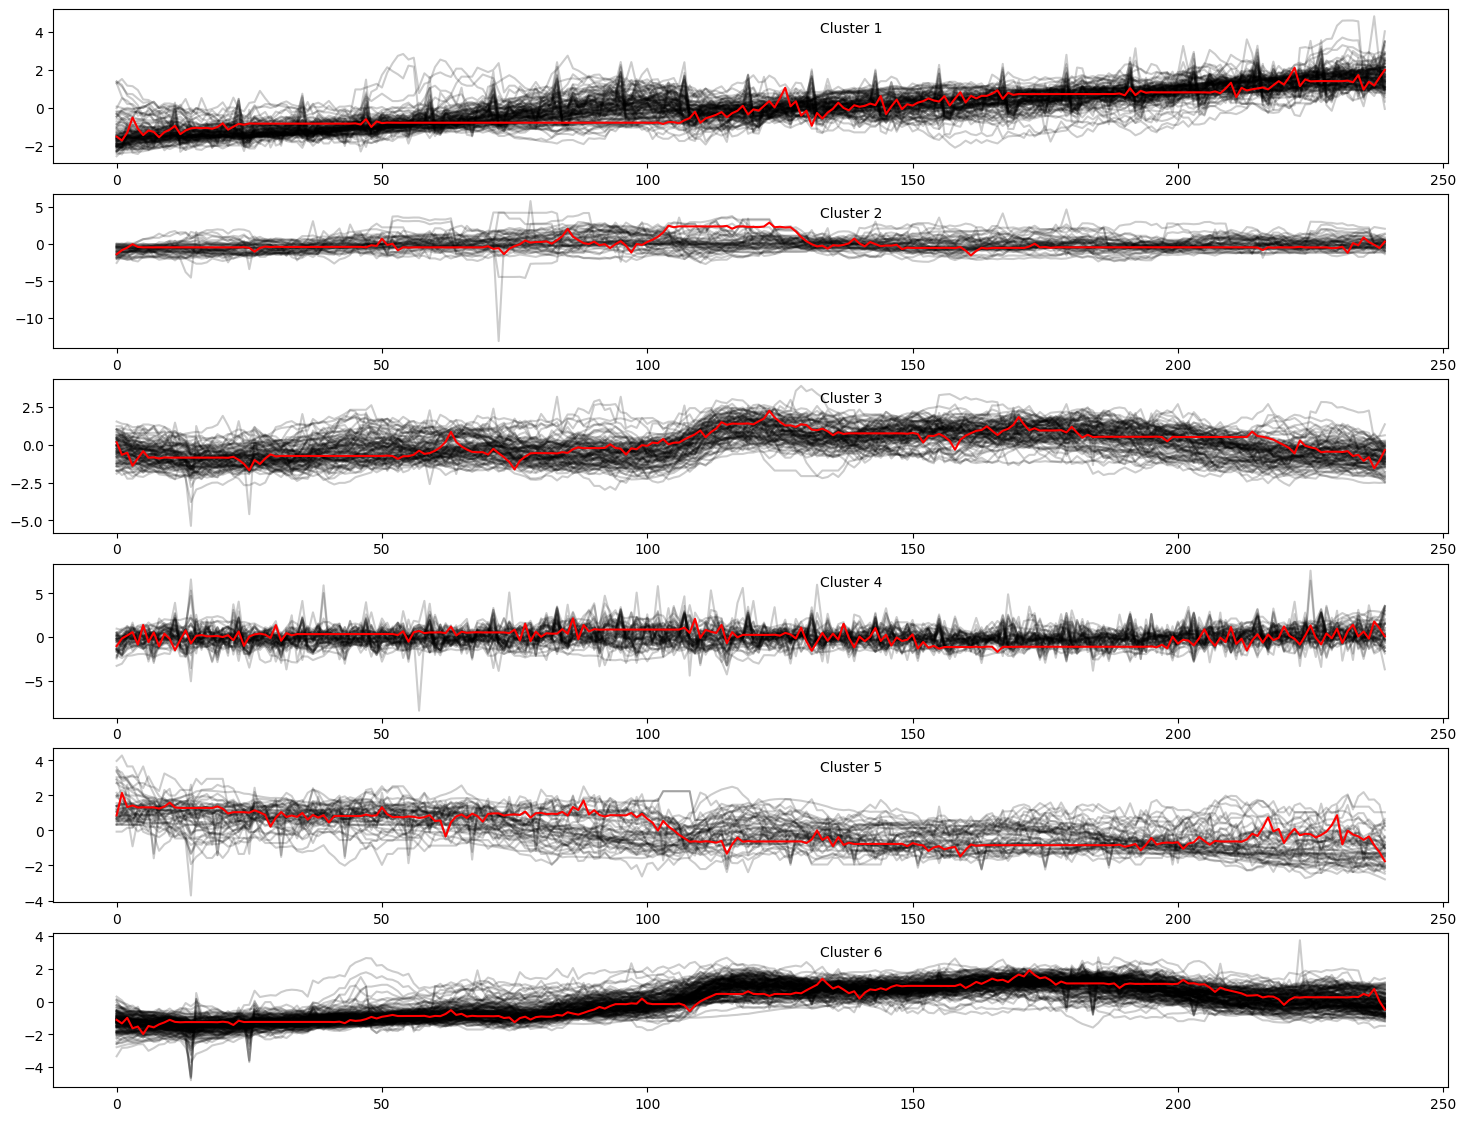

In [29]:
CLUSTER_COUNT = 6
# km = TimeSeriesKMeans(n_clusters=CLUSTER_COUNT, metric="dtw", n_jobs=2, n_init=5)
# labels = km.fit_predict(X_train)

plt.figure(figsize=(18,14))

for yi in range(CLUSTER_COUNT):
    plt.subplot(CLUSTER_COUNT, 1, yi + 1)
    for xx in X_train[labels == yi]:
        plt.plot(xx.ravel(), "k-", alpha=0.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    # plt.xlim(0, 1000)
    # plt.ylim(-4, 4)
    plt.text(0.55, 0.85, "Cluster %d" % (yi + 1), transform=plt.gca().transAxes)


In [61]:
# { i: column_name for i, column_name in enumerate(normalized_final_df.columns) }
# cluster_serie_indices = np.where(labels == i)[0]

column_names = np.array(normalized_final_df.columns)

cluster_sizes = []
names_by_cluster = []
series_by_cluster = []

for i in range(CLUSTER_COUNT):
    cluster_series = X_train[labels == i]
    series_by_cluster.append(cluster_series)

    cluster_serie_names = column_names[labels == i]
    names_by_cluster.append(cluster_serie_names)

    cluster_size = len(cluster_series)
    cluster_sizes.append(cluster_size)


In [65]:
names_by_cluster[2]

array(["Emissions nettes d'actions côtées (yc opérations d'apport en nature), Sociétés non financières, Valeur de marché (SEC 95), Flux cumulés 12 mois glissants",
       'Emissions nettes de titres de dette des administrations publiques, Cumul annuel',
       'Emissions nettes (flux monétaire) de titres de dette à long terme, Administrations publiques, Valeur nominale, Flux cumulés 12 mois glissants',
       'Danemark, Taux de chômage (CVS)',
       'Royaume-Uni, Taux de chômage (CVS)',
       'Grèce, Indice de ventes au détail (CJO)',
       'Grèce, Indice de ventes au détail (CVS-CJO)',
       'Hongrie, Taux de chômage (CVS)',
       'Lettonie, Taux de chômage (CVS)', 'Suède, Taux de chômage (CVS)',
       'Etats-Unis, Taux de chômage (CVS)',
       'Union Européenne, Taux de chômage (CVS)',
       'Taux de chômage au sens du BIT - Ensemble - France métropolitaine - Données CVS',
       'Autriche, Taux de chômage (CVS)',
       'Belgique, Taux de chômage (CVS)', 'Italie, Taux de chô